<a href="https://colab.research.google.com/github/bavilaa/adv_ml/blob/master/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications  import VGG19, ResNet50, InceptionV3


In [2]:
# After saving the following zip file to your working directory extract all files and folders from zip file to local folder.

!unzip brain_tumor_dataset.zip  

Archive:  brain_tumor_dataset.zip
replace brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# Extracting all filenames iteratively from brain_tumor_dataset folder
base_path = 'brain_tumor_dataset'
categories = ['yes', 'no']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

#print('number of images for each category:', [len(f) for f in fnames])
#print(fnames[0:4]) #examples of file names

In [4]:
# Let's explore the details of the image data using load_img from keras
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import numpy as np
from PIL import Image

img = load_img('brain_tumor_dataset/yes/Y26.jpg')
# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)

# It's an RGB image, so we can import using the following approach.

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(628, 630)


Using TensorFlow backend.


In [0]:
# Import image, load to array of shape height, width, channels, then min/max transform.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def load_image(img_path):
        img = Image.open(img_path).convert("RGB").resize((224,224)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-np.float32(img).min())/(np.float32(img).max()-np.float32(img).min()) # min max transformation
        img=img.reshape((224,224,3)) # Create final shape as array with correct dimensions for Keras
        return img

# read in all images from filenames

preprocessed_image_data=list(map(load_image, fnames[0]+fnames[1])) 

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model


In [6]:
print(len(preprocessed_image_data) ) #same number of elements as filenames
print(preprocessed_image_data[0].shape ) #dimensions now 192,192,3 for all images
print(preprocessed_image_data[0].min() ) #min value of every image is zero
print(preprocessed_image_data[0].max() ) #max value of every image is one
X.shape # 

253
(224, 224, 3)
0.0
1.0


(253, 224, 224, 3)

In [7]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

yes=list(repeat("yes", 155))
no=list(repeat("no", 98))


#combine into single list of y labels
y_labels = yes+no

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

#display(y)

253


In [8]:
# Train test split resized images
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)


y_train 


,no,yes
38,0,1
143,0,1
84,0,1
55,0,1
217,1,0
...,...,...
106,0,1
14,0,1
92,0,1
179,1,0


# 1.Visualize brain tumor images that demonstrate when images have tumors and when they do not have tumors.

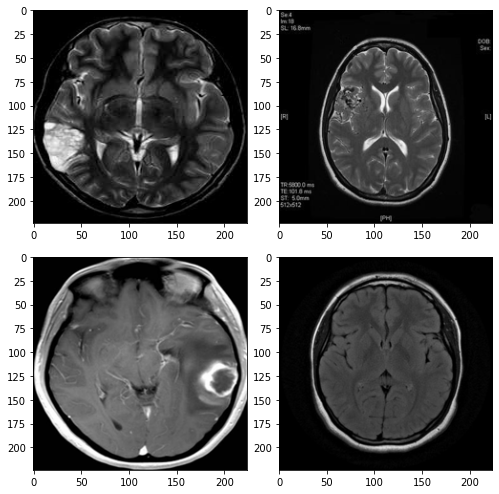

In [9]:
fig,ax=plt.subplots(2,2)
fig.set_size_inches(7,7)


#Tumor ==1
ax[0,0].imshow(X[1])
ax[1,0].imshow(X[2])

#Tumor == 0

ax[0,1].imshow(X[170])
ax[1,1].imshow(X[161])

#ax[0,0].imshow(X[0])
#ax[i,j].set_title('Tumor: '+y_labels[l])
        
plt.tight_layout()

* Discuss why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.

There are several reasons to use  machine learning to predict the existence of a tumor:

- Faster predictions. Computers cand read and process a lot of images at the same time, making the predictions faster than if they were issue by humans.
- Criteria could be more homogeneous. In cases when health professionals have doubts, a machine could help to standardize criteria to decide if they were a tumor or not.
-Detect tumors difficult to see by humans. Some tumors could be difficult to identify by humans, but not for a machine. The machine could detect small changes of color in pixels that could be hard to see by humans.


Nevertheless, all of these advantages must be complemented by human analysis. The final decision should be submitted by humans and no computers because we are dealing with human lives.

# Run at least three prediction models to try to predict brain tumor MRI images well.


* VGG 19 Transfer learning:

In [10]:
# example of loading the vgg16 model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model VGG16
base_model = VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
# Next step: Freeze the weights of the VGG16 model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
model = Sequential([
  base_model,
   GlobalAveragePooling2D(),
   Dense(2,activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 20,025,410
Trainable params: 1,026
Non-trainable params: 20,024,384
_________________________________________________________________


In [13]:

# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 15, verbose=1,validation_data=(X_test,y_test))

Epoch 1/15
7/7 [==============================] - 4s 524ms/step - loss: 0.6321 - acc: 0.6485 - val_loss: 0.6991 - val_acc: 0.5294
Epoch 2/15
7/7 [==============================] - 2s 224ms/step - loss: 0.6054 - acc: 0.6337 - val_loss: 0.6892 - val_acc: 0.5294
Epoch 3/15
7/7 [==============================] - 2s 241ms/step - loss: 0.5963 - acc: 0.6337 - val_loss: 0.6644 - val_acc: 0.5294
Epoch 4/15
7/7 [==============================] - 2s 224ms/step - loss: 0.6038 - acc: 0.6436 - val_loss: 0.6521 - val_acc: 0.5490
Epoch 5/15
7/7 [==============================] - 2s 223ms/step - loss: 0.5761 - acc: 0.7079 - val_loss: 0.6370 - val_acc: 0.5686
Epoch 6/15
7/7 [==============================] - 2s 224ms/step - loss: 0.5670 - acc: 0.6931 - val_loss: 0.6544 - val_acc: 0.5490
Epoch 7/15
7/7 [==============================] - 2s 225ms/step - loss: 0.5613 - acc: 0.6436 - val_loss: 0.6575 - val_acc: 0.5490
Epoch 8/15
7/7 [==============================] - 2s 224ms/step - loss: 0.5526 - acc: 0.69

# Model 2: Inception + Resnet model

In [29]:
#Inception model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model VGG16
base_model = InceptionResNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_213 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 111, 111, 32) 96          conv2d_213[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 111, 111, 32) 0           batch_normalization_203[0][0]    
________________________________________________________________________________

In [30]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_213 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 111, 111, 32) 96          conv2d_213[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 111, 111, 32) 0           batch_normalization_203[0][0]    
________________________________________________________________________________

In [31]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
model = Sequential([
  base_model,
   GlobalAveragePooling2D(),
   Dense(2,activation="softmax")
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 3,074
Non-trainable params: 54,336,736
_________________________________________________________________


In [32]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 10, verbose=1,validation_data=(X_test,y_test))

Epoch 1/10
7/7 [==============================] - 5s 654ms/step - loss: 0.7443 - acc: 0.5347 - val_loss: 0.7205 - val_acc: 0.5686
Epoch 2/10
7/7 [==============================] - 2s 232ms/step - loss: 0.5016 - acc: 0.7723 - val_loss: 0.4739 - val_acc: 0.7451
Epoch 3/10
7/7 [==============================] - 2s 230ms/step - loss: 0.3828 - acc: 0.8465 - val_loss: 0.4698 - val_acc: 0.7647
Epoch 4/10
7/7 [==============================] - 2s 231ms/step - loss: 0.3442 - acc: 0.8564 - val_loss: 0.4513 - val_acc: 0.7843
Epoch 5/10
7/7 [==============================] - 2s 232ms/step - loss: 0.3091 - acc: 0.8713 - val_loss: 0.4066 - val_acc: 0.8039
Epoch 6/10
7/7 [==============================] - 2s 232ms/step - loss: 0.2775 - acc: 0.8911 - val_loss: 0.4093 - val_acc: 0.8039
Epoch 7/10
7/7 [==============================] - 2s 231ms/step - loss: 0.2627 - acc: 0.9059 - val_loss: 0.4550 - val_acc: 0.7647
Epoch 8/10
7/7 [==============================] - 2s 231ms/step - loss: 0.2638 - acc: 0.88

In [33]:
model.history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

#Model 3: CNN

In [19]:

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size 192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=[224, 224, 3]),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(2, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 2, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/2
7/7 [==============================] - 1s 185ms/step - loss: 0.7084 - accuracy: 0.6535 - val_loss: 0.7168 - val_accuracy: 0.5294
Epoch 2/2
7/7 [==============================] - 1s 88ms/step - loss: 0.6385 - accuracy: 0.6337 - val_loss: 0.6722 - val_accuracy: 0.5294


The basic CNN is the worst model. It was a expected result, because compared with VGG19 or Inception this CNN doesn't have pretrained weight values. 

Inception has better perfomance than VGG, this could be because in Inception model there are the double of pretrained parameters 50M against 22M.


#Submit the best model:

In [20]:
#install aimodelshare library (version 0.0.3 last updated 3/6/2020)
! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true


# Load libraries for onnx model conversion (keras to onnx)
! pip3 install keras2onnx
! pip3 install onnxruntime

  Using cached https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true
  Created wheel for aimodelshare: filename=aimodelshare-0.0.5-cp36-none-any.whl size=5305 sha256=b80720e85f8225cab8af28afc749a17a7ec39384586e1fcc2ae0b388f1f841cc
  Stored in directory: /root/.cache/pip/wheels/ab/28/ae/b9ecb7a3a5542d3f2fed56649fdd6dec1c16f900ef70b93875
Successfully built aimodelshare


In [21]:
import os
os.environ['TF_KERAS'] = '1' # Add this environmental variable whenever you use tensorflow's tf.keras to build your keras model
import onnx

import keras2onnx

from keras2onnx import convert_keras
onx = convert_keras(model, 'my_model.onnx')
with open("my_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

Can't import tf2onnx module, so the conversion on a model with any custom/lambda layer will fail!


In [22]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

raw_predictions=model.predict(X_test)
print(predict_classes(raw_predictions))

prediction_index=predict_classes(raw_predictions)

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']


In [0]:
# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [24]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.529412,0.346154,0.264706,0.5,0,0,0,0


In [25]:
# add metrics to submittable object
modelevalobject=model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")


modelevalobject# add metrics to submittable object


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.529412,0.346154,0.264706,0.5,0,0,0,0


In [0]:
# Example Model Pre-launched into Model Share Site
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
#username = "your ai model share username"
#password = "your ai model share password"
username = 
password = 


model_filepath="my_model.onnx"   

# New! Assign model object to model argument parameter to submit model architecture to leaderboard.
model=model

# Set aws keys for this project (these keys give you access to collaborate on a single project)

#Importing from object that stores keys so we do not print out keys for others to see.

import pickle
aws_key_password_region = pickle.load( open( "braintumor_modelsubmission_keys.pkl", "rb" ) )

aws_key=aws_key_password_region[0]
aws_password=aws_key_password_region[1]
region=aws_key_password_region[2]

In [34]:
# Submit your model using submit_model() function
# Works with models and preprocessors. 
import aimodelshare as ai

ai.submit_model(modelobject=model, model_filepath=model_filepath, model_eval_metrics=modelevalobject,apiurl=apiurl, username=username, password=password, aws_key=aws_key,aws_password=aws_password, region=region, trainingdata="default",preprocessor_filepath="default",preprocessor="default")


"my_model.onnx" has been loaded to version 45 of your prediction API.
This version of the model will be used by your prediction api for all future predictions automatically.
If you wish to use an older version of the model, please reference the getting started guide at aimodelshare.com.


#Loading the best Model:

In [35]:
# Check leaderboard
import aimodelshare as ai

leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region).head(20)

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression,model_config,model_optim_config,model_epochs
15,0.941176,0.940812,0.942547,0.939815,0,0,0,0,Taketo,17,1.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
14,0.901961,0.901354,0.902950,0.900463,0,0,0,0,Taketo,16,2.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",10
16,0.875000,0.868718,0.868718,0.868718,0,0,0,0,3scman,18,3.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...",25
21,0.862745,0.862745,0.865741,0.865741,0,0,0,0,dhoward97,24,4.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 1.5625e-05, ...",25
23,0.862745,0.862534,0.862308,0.863426,0,0,0,0,seanmcalevey,26,5.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",50
17,0.823529,0.813187,0.875000,0.812500,0,0,0,0,AlisaAi,19,5.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",25
20,0.843137,0.841615,0.845611,0.840278,0,0,0,0,seanmcalevey,23,6.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",25
13,0.803922,0.802019,0.805643,0.800926,0,0,0,0,Taketo,15,8.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
30,0.803922,0.802019,0.805643,0.800926,0,0,0,0,XU,39,8.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
29,0.803922,0.802019,0.805643,0.800926,0,0,0,0,XU,38,8.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5


In [36]:
#Best model was model number 15

# Import and print model details from leaderboard
model_config= leaderboard.loc[15,'model_config'] # model details best model (i.e.-row #1)
model_optim_config= leaderboard.loc[15,'model_optim_config'] # model details best model (i.e.-row #1)

print(model_config)
print(model_optim_config)

backend: tensorflow
class_name: Sequential
config:
  build_input_shape: !!python/object/apply:tensorflow.python.framework.tensor_shape.TensorShape
  - - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [null]
    - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [224]
    - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [224]
    - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [3]
  layers:
  - class_name: Model
    config:
      batch_input_shape: !!python/tuple [null, 224, 224, 3]
      input_layers:
      - [input_17, 0, 0]
      layers:
      - class_name: InputLayer
        config:
          batch_input_shape: !!python/tuple [null, 224, 224, 3]
          dtype: float32
          name: input_17
          ragged: false
          sparse: false
        inbound_nodes: []
        name: input_17
      - class_name: Conv2D
        config:
          activation: linear
          activity_re

In [37]:
# Import model config to use to fit same architecture to new data
from tensorflow.keras.models import model_from_yaml
model = model_from_yaml(model_config)
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 32,738
Non-trainable params: 21,774,144
_________________________________________________________________


In [39]:
#Fit the best model and evaluate:

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 15, verbose=1,validation_data=(X_test,y_test))

Epoch 1/15
7/7 [==============================] - 4s 582ms/step - loss: 0.6765 - acc: 0.6337 - val_loss: 0.6922 - val_acc: 0.5294
Epoch 2/15
7/7 [==============================] - 2s 223ms/step - loss: 0.6560 - acc: 0.6337 - val_loss: 0.6897 - val_acc: 0.5294
Epoch 3/15
7/7 [==============================] - 2s 224ms/step - loss: 0.6416 - acc: 0.6337 - val_loss: 0.6867 - val_acc: 0.5294
Epoch 4/15
7/7 [==============================] - 2s 225ms/step - loss: 0.6273 - acc: 0.6337 - val_loss: 0.6833 - val_acc: 0.5294
Epoch 5/15
7/7 [==============================] - 2s 225ms/step - loss: 0.6267 - acc: 0.6337 - val_loss: 0.6810 - val_acc: 0.5294
Epoch 6/15
7/7 [==============================] - 2s 225ms/step - loss: 0.6247 - acc: 0.6337 - val_loss: 0.6789 - val_acc: 0.5294
Epoch 7/15
7/7 [==============================] - 2s 224ms/step - loss: 0.6061 - acc: 0.6337 - val_loss: 0.6808 - val_acc: 0.5294
Epoch 8/15
7/7 [==============================] - 2s 223ms/step - loss: 0.6317 - acc: 0.63